In [1]:
# Makes the display take up more of the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os
import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
import time

In [4]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
def set_seed(x): 
    #random.seed(x)
    np.random.seed(x)
    T.manual_seed(x)
    T.backends.cudnn.deterministic = True
    T.backends.cudnn.benchmark = False
    if T.cuda.is_available(): 
        T.cuda.manual_seed_all(x)

In [6]:
seed= 42
set_seed(seed)

In [7]:
class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones


In [14]:
class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions,
            name, chkpt_dir='Models/td3'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_td3')

        # I think this breaks if the env has a 2D state representation
        self.fc1 = nn.Linear(self.input_dims[0] + n_actions, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.q1 = nn.Linear(self.fc2_dims, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.to(self.device)

    def forward(self, state, action):
        q1_action_value = self.fc1(T.cat([state, action], dim=1))
        q1_action_value = F.relu(q1_action_value)
        q1_action_value = self.fc2(q1_action_value)
        q1_action_value = F.relu(q1_action_value)

        q1 = self.q1(q1_action_value)

        return q1

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

In [15]:
class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims,
                n_actions, name, chkpt_dir='Models/td3'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_td3')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.mu = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.to(self.device)

    def forward(self, state):
        prob = self.fc1(state)
        prob = F.relu(prob)
        prob = self.fc2(prob)
        prob = F.relu(prob)

        prob = T.tanh(self.mu(prob)) # if action is > +/- 1 then multiply by max action

        return prob

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))


In [16]:
class Agent():
    def __init__(self, alpha, beta, input_dims, tau, env,
            gamma=0.99, update_actor_interval=2, warmup=1000,
            n_actions=2, max_size=1000000, layer1_size=400,
            layer2_size=300, batch_size=100, noise=0.1):
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.tau = tau
        self.max_action = env.action_space.high
        self.min_action = env.action_space.low
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size
        self.learn_step_cntr = 0
        self.time_step = 0
        self.warmup = warmup
        self.n_actions = n_actions
        self.update_actor_iter = update_actor_interval

        self.actor = ActorNetwork(self.alpha, input_dims, layer1_size,
                                  layer2_size, n_actions=n_actions,
                                  name='actor')
        self.critic_1 = CriticNetwork(self.beta, input_dims, layer1_size,
                                      layer2_size, n_actions=n_actions,
                                      name='critic_1')
        self.critic_2 = CriticNetwork(self.beta, input_dims, layer1_size,
                                      layer2_size, n_actions=n_actions,
                                      name='critic_2')

        self.target_actor = ActorNetwork(self.alpha, input_dims, layer1_size,
                                         layer2_size, n_actions=n_actions,
                                         name='target_actor')
        self.target_critic_1 = CriticNetwork(self.beta, input_dims, layer1_size,
                                         layer2_size, n_actions=n_actions,
                                         name='target_critic_1')
        self.target_critic_2 = CriticNetwork(self.beta, input_dims, layer1_size,
                                         layer2_size, n_actions=n_actions,
                                         name='target_critic_2')

        self.noise = noise
        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        if self.time_step < self.warmup:
            mu = T.tensor(np.random.normal(scale=self.noise, size=(self.n_actions,)))
        else:
            state = T.tensor(observation, dtype=T.float).to(self.actor.device)
            mu = self.actor.forward(state).to(self.actor.device)
        mu_prime = mu + T.tensor(np.random.normal(scale=self.noise),
                dtype=T.float).to(self.actor.device)
        mu_prime = T.clamp(mu_prime, self.min_action[0], self.max_action[0])
        self.time_step += 1
        return mu_prime.cpu().detach().numpy()

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        state, action, reward, new_state, done = \
                self.memory.sample_buffer(self.batch_size)

        reward = T.tensor(reward, dtype=T.float).to(self.critic_1.device)
        done = T.tensor(done).to(self.critic_1.device)
        state_ = T.tensor(new_state, dtype=T.float).to(self.critic_1.device)
        state = T.tensor(state, dtype=T.float).to(self.critic_1.device)
        action = T.tensor(action, dtype=T.float).to(self.critic_1.device)

        target_actions = self.target_actor.forward(state_)
        target_actions = target_actions + \
                T.clamp(T.tensor(np.random.normal(scale=0.2)), -0.5, 0.5)
        # might break if elements of min and max are not all equal
        target_actions = T.clamp(target_actions, self.min_action[0], self.max_action[0])

        q1_ = self.target_critic_1.forward(state_, target_actions)
        q2_ = self.target_critic_2.forward(state_, target_actions)

        q1 = self.critic_1.forward(state, action)
        q2 = self.critic_2.forward(state, action)

        q1_[done] = 0.0
        q2_[done] = 0.0

        q1_ = q1_.view(-1)
        q2_ = q2_.view(-1)

        critic_value_ = T.min(q1_, q2_)

        target = reward + self.gamma*critic_value_
        target = target.view(self.batch_size, 1)

        self.critic_1.optimizer.zero_grad()
        self.critic_2.optimizer.zero_grad()

        q1_loss = F.mse_loss(target, q1)
        q2_loss = F.mse_loss(target, q2)
        critic_loss = q1_loss + q2_loss
        critic_loss.backward()

        self.critic_1.optimizer.step()
        self.critic_2.optimizer.step()

        self.learn_step_cntr += 1

        if self.learn_step_cntr % self.update_actor_iter != 0:
            return

        self.actor.optimizer.zero_grad()
        actor_q1_loss = self.critic_1.forward(state, self.actor.forward(state))
        actor_loss = -T.mean(actor_q1_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_1_params = self.critic_1.named_parameters()
        critic_2_params = self.critic_2.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_1_params = self.target_critic_1.named_parameters()
        target_critic_2_params = self.target_critic_2.named_parameters()

        critic_1_state_dict = dict(critic_1_params)
        critic_2_state_dict = dict(critic_2_params)
        actor_state_dict = dict(actor_params)
        target_actor_state_dict = dict(target_actor_params)
        target_critic_1_state_dict = dict(target_critic_1_params)
        target_critic_2_state_dict = dict(target_critic_2_params)

        for name in critic_1_state_dict:
            critic_1_state_dict[name] = tau*critic_1_state_dict[name].clone() + \
                    (1-tau)*target_critic_1_state_dict[name].clone()

        for name in critic_2_state_dict:
            critic_2_state_dict[name] = tau*critic_2_state_dict[name].clone() + \
                    (1-tau)*target_critic_2_state_dict[name].clone()

        for name in actor_state_dict:
            actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                    (1-tau)*target_actor_state_dict[name].clone()

        self.target_critic_1.load_state_dict(critic_1_state_dict)
        self.target_critic_2.load_state_dict(critic_2_state_dict)
        self.target_actor.load_state_dict(actor_state_dict)

    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()
        self.target_critic_1.save_checkpoint()
        self.target_critic_2.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic_1.load_checkpoint()
        self.critic_2.load_checkpoint()
        self.target_critic_1.load_checkpoint()
        self.target_critic_2.load_checkpoint()

In [17]:
env = gym.make('LunarLanderContinuous-v2')
#env = gym.make('BipedalWalker-v2')
env.seed(seed)
agent = Agent(alpha=0.001, beta=0.001, 
                input_dims=env.observation_space.shape, tau=0.005,
                env=env, batch_size=100, layer1_size=400, layer2_size=300,
                n_actions=env.action_space.shape[0])
n_games = 301
filename = 'LunarLander_alpha_' + str(agent.alpha) + '_beta_' + \
            str(agent.beta) + '_' + str(n_games) + '_games'
#filename = 'Walker_2D' + str(agent.alpha) + '_beta_' + \
#            str(agent.beta) + '_' + str(n_games) + '_games'

best_score = env.reward_range[0]
episode_time=[]
score_history = []
for i in range(n_games):
    toc= time.time()
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        agent.remember(observation, action, reward, observation_, done)
        agent.learn()
        score += reward
        observation = observation_
    score_history.append(score)
    tic=time.time()
    episode_time.append(tic-toc)
    
    intvl=10
    avg_score = np.mean(score_history[-intvl:])
    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()

    
    if i % intvl == 0:        
        avg_time = np.mean(episode_time[-intvl:])
        print('Episode ', i, 'Score %.2f' % score, 'Average score %.2f' % avg_score, 'Average episode time %.2f' % avg_time, '(sec)')
env.close()

... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
Episode  0 Score -174.68 Average score -174.68 Average episode time 0.25 (sec)
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
Episode  10 Score -863.95 Average score -265.65 Average episode time 1.31 (sec)
Episode  20 Score -623.98 Average score -560.08 Average episode time 0.91 (sec)
Episode  30 Score -531.27 Average score -487.67 Average episode time 0.96 (sec)
Episode  40 Score -355.39 Average score -571.71 Average episode time 1.04 (sec)
Episode  50 Score -854.02 Average score -521.35 Average episode time 0.89 (sec)
Episode  60 Score -435.01 Average score -561.47 Average episode time 0.96 (sec)
Episode  70 Score -531.76 Average score -595.70 Average episode time 0.99 (sec)
Episode  80 Score -450.97 Average score -530.30 A

In [18]:
print('Time to complete %.2f', np.array(episode_time).sum()/60, '(minutes)')

Time to complete %.2f 5.094084310531616 (minutes)


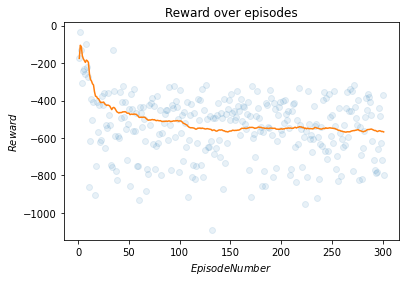

In [19]:
x = [i+1 for i in range(len(score_history))]
running_avg = np.zeros(len(score_history))
for i in range(len(running_avg)):
    running_avg[i] = np.mean(score_history[max(0, i-100):(i+1)])

plt.plot(x, score_history, 'o', alpha=0.1)
plt.plot(x, running_avg)
plt.title('Reward over episodes')
plt.ylabel(r'$Reward$')
plt.xlabel(r'$Episode Number$')
plt.show()

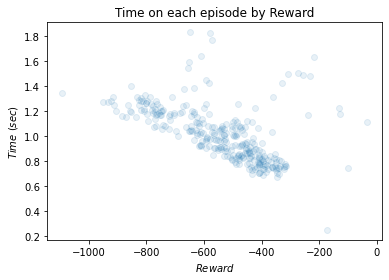

In [20]:
x = score_history
y=episode_time
plt.plot(x, y, 'o', alpha=0.1)

plt.title('Time on each episode by Reward')
plt.ylabel(r'$Time \ (sec)$')
plt.xlabel(r'$Reward$')
plt.show()

# Fin

In [21]:
end=dt.datetime.now()
print(f'Finished: {end.strftime("%A %B %d, %Y")} at {end.strftime("%H:%M")}')

Finished: Monday October 18, 2021 at 13:48
